# Term2 Sprint12 授業課題 
## コーディング課題：畳み込みニューラルネットワーク(CNN)スクラッチ1

NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していく。

Sprint11で作成したディープニューラルネットワークのクラスを拡張する形でCNNを作成する。  
まず、Sprint12で1次元畳み込み層を作成し、畳み込みの基礎を理解することを目指す。  
そして、Sprint13で一般的に画像に対して使われる2次元畳み込み層とプーリング層を作成する。

**1次元畳み込み層**  
畳み込みニューラルネットワークは画像に対して使われる2次元畳み込みが代表的だが、理解を容易にするためにまずは1次元畳み込みを実装する。  
1次元畳み込みは系列データで使われることが多い。  
畳み込みは任意の次元に対して考えることができ、立体データに対しての3次元畳み込みまでがフレームワークで一般的に用意されている。

**データセットの用意**  
引き続きMNISTデータセットを使用する。  
1次元畳み込みでは全結合のニューラルネットワークと同様に平滑化されたものを入力する。

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pyprind
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [282]:
# データ生成
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 平滑化
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

# 正規化
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

# 訓練データから更に検証データを生成
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

**CNN分類器クラスの作成**  
1次元畳み込みニューラルネットワークモデルのクラスScratch1dCNNClassifierを作成する。  
Sprint11で作成したScratchDeepNeuralNetworkClassifierを元にする。

## 1. チャンネル数を1に限定した1次元畳み込み層クラスの作成
チャンネル数を1に限定した1次元畳み込み層のクラスSimpleConv1dを作成する。  
基本構造はsprint11で作成したFCクラスと同じになる。  
なお、重みの初期化に関するクラスは必要に応じて作り変える。Xavierの初期値などを使う点は全結合層と同様。

ここではパディングは考えず、ストライドも1に固定する。  
また、複数のデータを同時に処理することも考えなくて良く、バッチサイズは1のみに対応する。  
この部分の拡張はアドバンス課題とする。

フォワードプロパゲーションの数式は以下のようになる。
$$a_i = \sum_{s=0}^{F-1}x_{(i+s)}w_s+b$$
$a_i$ : 出力される配列のi番目の値  
$F$ : フィルタのサイズ  
$x_{(i+s)}$ : 入力の配列の(i+s)番目の値  
$w_s$ : 重みの配列のs番目の値  
$b$ : バイアス項

全てスカラーとなる。

次に更新式は以下のようになる。ここがAdaGradなどに置き換えられる点は全結合層と同様。
$$w_s^{\prime} = w_s - \alpha \frac{\partial L}{\partial w_s}$$

$$b^{\prime} = b - \alpha \frac{\partial L}{\partial b}$$

$\alpha$ : 学習率
$\frac{\partial L}{\partial w_s}$ : $w_s$に関する損失$L$の勾配
$\frac{\partial L}{\partial b}$ : $b$に関する損失$L$の勾配

勾配$\frac{\partial L}{\partial w_s}$や$\frac{\partial L}{\partial b}$を求めるためのバックプロパゲーションの数式は以下の通り。
$$\frac{\partial L}{\partial w_s} = \sum_{i=0}^{N_{out}-1} \frac{\partial L}{\partial a_i}x_{(i+s)}$$

$$\frac{\partial L}{\partial b} = \sum_{i=0}^{N_{out}-1} \frac{\partial L}{\partial a_i}$$

$\frac{\partial L}{\partial a_i}$ : 勾配の配列の$i$番目の値
$N_{out}$ : 出力のサイズ

前の層に流す誤差の数式は以下の通り。
$$\frac{\partial L}{\partial x_j} = \sum_{s=0}^{F-1} \frac{\partial L}{\partial a_{(j-s)}}w_s$$

$\frac{\partial L}{\partial x_j}$ : 前の層に流す誤差の配列の$j$番目の値

ただし、$j-s<0$または$j-s>N_{out}-1$のとき$\frac{\partial L}{\partial a_{(j-s)}}=0$となる。

全結合層との大きな違いは、重みが複数の特徴量に対して共有されていること。  
この場合は共有されている分の誤差を全て足すことで勾配を求める。  
計算グラフ上での分岐はバックプロパゲーションの際に誤差の足し算をすれば良いことになる。

In [151]:
class Conv1d_Initializer:
    """
    1次元畳み込み層(SimpleConv1dクラス)のコンストラクタに初期化方法のインスタンスとして渡す。
    メソッドWで乱数を用いて初期化する。

    Parameters
    ----------
    sigma : str, float or int
        正規分布の標準偏差の値または"Xavier", "He"のいずれかの文字列
    n : int
        前の層のノード数
        
    """
    def __init__(self, sigma, n):
        if (type(sigma) is float) or (type(sigma) is int):
            self.sigma = float(sigma)
        elif sigma == "Xavier":
            self.sigma = np.sqrt(1. / n)
        elif sigma == "He":
            self.sigma = np.sqrt(2. / n)
        else:
            raise ValueError("Set \"Xavier\" or \"He\" or numerical value (float or int).")
    
    def W(self, filter_size):
        return self.sigma * np.random.randn(filter_size)
    

class SimpleConv1d:
    """
    1次元畳み込み層クラス
    パディングなし、ストライドは1、バッチサイズも1
    
    Parameters
    ----------
    filter_size : int
      フィルターの要素数の個数
    initializer : instance
      初期化方法のインスタンス
    optimizer : instance
      最適化手法のインスタンス
    
    Attributes
    ----------
    self.z : 入力データ
      forwardの際に、後のbackward計算用に保存しておく入力データ
    
    """
    def __init__(self, filter_size, initializer, optimizer, trial=False):
        # initializerのメソッドを使い、self.wとself.bを初期化する
        self.w = initializer.W(filter_size)
        self.b = 0.
        # テスト時に使う値
        if trial:
            self.w = np.array([3, 5, 7])
            self.b = np.array([1])
        
    def forward(self, z):
        """
        Parameters
        ----------
        z : 入力データ
        
        Returns
        ----------
        a : 出力データ
        
        """
        # backward用に入力値zを保存しておく
        self.z = z
        # 出力するaの空配列を作成
        z_shape = z.shape[0]
        a = np.zeros(z_shape - (self.filter_size - 1))
        # aを計算して出力
        for i in range(len(a)):
            a[i] = np.dot(z[i : i + self.filter_size], self.w) + self.b
        return a
    
    def backward(self, grad_a):
        """
        Parameters
        ----------
        grad_a : 後ろから流れてきた勾配
        
        Returns
        ----------
        grad_z : 前に流す勾配
        
        """
        # w, bの勾配計算
        self.grad_w = np.zeros(self.filter_size)
        for i in range(self.filter_size):
            self.grad_w[i] = np.dot(self.z[i : i + grad_a.shape[0]], grad_a)
        self.grad_b = grad_a.sum(axis=0)
        
        # zの勾配計算用に、aの勾配にゼロ配列を追加
        grad_a_add = np.zeros(self.filter_size - 1)
        grad_a = np.hstack((grad_a, grad_a_add))
        
        # zの勾配計算
        index = np.empty((0, self.filter_size), int)
        for j in range(len(self.z)):
            index_to_add = np.arange(j - (self.filter_size-1), j+1)
            index = np.append(index, [index_to_add], axis=0)
        grad_a = np.flip(grad_a[index], axis=1)
        grad_z = np.dot(grad_a, self.w)
        
        # 更新(Trial時は実行しない)
        # self = self.optimizer.update(self)
        return grad_z


## 2. 1次元畳み込み後の出力サイズの計算
畳み込みを行うと特徴量の数が変化する。どのように変化するかは以下の数式から求められる。  
パディングやストライドも含めている。この計算を行う関数を作成する。

$$N_{out} =  \frac{N_{in}+2P-F}{S} + 1$$

$N_{out}$ : 出力のサイズ（特徴量の数）  
$N_{in}$ : 入力のサイズ（特徴量の数）  
$P$ : ある方向へのパディングの数  
$F$ : フィルタのサイズ  
$S$ : ストライドのサイズ

In [152]:
def feature_calc(n_in, p, f, s):
    n_out = (n_in + (2 * p) - f) / s + 1
    return n_out

## 3. 小さな配列での1次元畳み込み層の実験
次に示す小さな配列でフォワードプロパゲーションとバックプロパゲーションが正しく行えているか確認する。  
入力$x$、重み$w$、バイアス$b$を次のようにする。


In [153]:
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])

フォワードプロパゲーションをすると出力は次のようになる。

In [154]:
a = np.array([35, 50])

## Forwardを実際に実行

In [155]:
# フィルター要素の個数
filter_size = 3

# 初期化クラス(今回はテスト施行なので, 使用しないsigmaとnは任意の値を入力)
initializer = Conv1d_Initializer(1,1)

sc_1d = SimpleConv1d(filter_size, initializer, trial=True)
a = sc_1d.forward(x)
print("Forward出力(a): ", a)

Forward出力(a):  [35. 50.]


次にバックプロパゲーションを考える。誤差は次のようであったとする。

In [156]:
delta_a = np.array([10, 20])

バックプロパゲーションをすると次のような値になる。

In [157]:
delta_b = np.array([30])
delta_w = np.array([50, 80, 110])
delta_x = np.array([30, 110, 170, 140])

## Backwardを実際に実行

In [158]:
delta_x = sc_1d.backward(delta_a)
print("Backward出力(delta_b): ", sc_1d.grad_b)
print("Backward出力(delta_w): ", sc_1d.grad_w)
print("Backward出力(delta_x): ", delta_x)

Backward出力(delta_b):  30
Backward出力(delta_w):  [ 50.  80. 110.]
Backward出力(delta_x):  [ 30. 110. 170. 140.]


**上記のBackwardの勾配計算で施した実装上の工夫**  
畳み込みを実装する場合は、まずはfor文を重ねていく形で構わない。  
しかし、できるだけ計算は効率化させたいため、以下の式を一度に計算する方法を考える。
$$a_i = \sum_{s=0}^{F-1}x_{(i+s)}w_s+b$$

バイアス項は単純な足し算のため、重みの部分を見る。  
$$\sum_{s=0}^{F-1}x_{(i+s)}w_s$$

これは、xの一部を取り出した配列とwの配列の内積である。  
具体的な状況を考えると、以下のようなコードで計算できる。  
この例では流れを分かりやすくするために、各要素同士でアダマール積を計算してから合計を計算している。  
これは結果的に内積と同様となる。

In [ ]:
x = np.array([1, 2, 3, 4])
w = np.array([3, 5, 7])

a = np.empty((2, 3))

indexes0 = np.array([0, 1, 2]).astype(np.int)
indexes1 = np.array([1, 2, 3]).astype(np.int)

a[0] = x[indexes0]*w # x[indexes0]は([1, 2, 3])である
a[1] = x[indexes1]*w # x[indexes1]は([2, 3, 4])である

a = a.sum(axis=1)

ndarrayは配列を使ったインデックス指定ができることを利用した方法である。  
また、二次元配列を使えば一次元配列から二次元配列が取り出せる。

In [ ]:
x = np.array([1, 2, 3, 4])
indexes = np.array([[0, 1, 2], [1, 2, 3]]).astype(np.int)

print(x[indexes]) # ([[1, 2, 3], [2, 3, 4]])

このこととブロードキャストなどをうまく組み合わせることで、一度にまとめて計算することも可能。

畳み込みの計算方法に正解はないので、自分なりに効率化していく。

**参考**

以下のページのInteger array indexingの部分がこの方法についての記述である。

[Indexing — NumPy v1.15 Manual](https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html "Indexing — NumPy v1.15 Manual")



## 4. チャンネル数を限定しない1次元畳み込み層クラスの作成
チャンネル数を1に限定しない1次元畳み込み層のクラスConv1dを作成する。

紙やホワイトボードを使い計算グラフを書きながら考える。

例えば以下のような$x$, $w$, $b$があった場合は、

In [274]:
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) # shape(2, 4)で、（入力チャンネル数、特徴量数）
w = np.ones((3, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)
b = np.array([1, 2, 3]) # （出力チャンネル数）

出力は次のようになる。

In [ ]:
a = np.array([[16, 22], [17, 23], [18, 24]]) # shape(3, 2)で、（出力チャンネル数、特徴量数）である。

入力が2チャンネル、出力が3チャンネルの例となる。  
計算グラフを書いた上で、バックプロパゲーションも手計算で考えてみる。  
計算グラフの中には和と積しか登場しないので、微分を新たに考える必要はない。

**補足**

チャンネル数を加える場合、配列をどういう順番にするかという問題がある。  
(バッチサイズ、チャンネル数、特徴量数)または(バッチサイズ、特徴量数、チャンネル数)が一般的で、ライブラリによって順番は異なる。（切り替えて使用できるものもある）

今回のスクラッチでは自身の実装上どちらが効率的かを考えて選ぶ。  
上記の例ではバッチサイズは考えておらず、(チャンネル数、特徴量数)となっている。

In [277]:
class Conv1d:
    """
    1次元畳み込み層クラス
    パディングなし、ストライドは1、バッチサイズも1
    
    Parameters
    ----------
    filter_size : int
      フィルターの要素数の個数
    initializer : instance
      初期化方法のインスタンス
    optimizer : instance
      最適化手法のインスタンス
    
    Attributes
    ----------
    self.z : 入力データ
      forwardの際に、後のbackward計算用に保存しておく入力データ
    
    """
    def __init__(self, filter_size, initializer, trial=False):
        # initializerのメソッドを使い、self.wとself.bを初期化する
        self.w = initializer.W(filter_size)
        self.b = 0.
        # テスト時に使う値
        if trial:
            self.w = w
            self.b = b
        
    def forward(self, z):
        """
        Parameters
        ----------
        z : 入力データ
        
        Returns
        ----------
        a : 出力データ
        
        """
        FN, C, FS = self.w.shape # (出力チャンネル数、入力チャンネル数、フィルタサイズ)
        C, W = z.shape # (入力チャンネル数、特徴量数)
        
        # backward用に入力値zを保存しておく
        self.z = z
        # 出力するaの空配列を作成
        a = np.zeros((FN, (W - (FS - 1)))) # (出力チャンネル数、特徴量数)
        # aを計算して出力
        for i in range(FN):
            index = np.empty((0, FS), int)
            for j in range(W - (FS - 1)):
                index_to_add = np.arange(j, j+FS)
                index = np.append(index, [index_to_add], axis=0)
            a[i] = (z[:, index] * self.w[i]).sum(axis=1).sum(axis=1)
        a += self.b.reshape(-1,1)
        return a  
    
    def backward(self, grad_a):
        """
        Parameters
        ----------
        grad_a : 後ろから流れてきた勾配
        
        Returns
        ----------
        grad_z : 前に流す勾配
        
        """
        FN, C, FS = self.w.shape # (出力チャンネル数、入力チャンネル数、フィルタサイズ)
        C, W = self.z.shape # (入力チャンネル数、特徴量数)
        
        # wの勾配計算
        self.grad_w = np.zeros(self.w.shape)
        for i in range(FS):
            for j in range(W - (FS - 1)):
                self.grad_w[:, :, i] += grad_a[:, j][:, np.newaxis] * self.z[:, j][np.newaxis, :]
        
        # bの勾配計算
        self.grad_b = grad_a.sum(axis=1)
        
        # zの勾配計算
        grad_z = np.zeros(self.z.shape)
        for i in range(W - (FS - 1)):
            for j in range(FS):
                grad_z[:, i+j] += (grad_a[:, i][:, np.newaxis] * self.w[:, :, j]).sum(axis=0)
        
        # 更新(Trial時は実行しない)
        # self = self.optimizer.update(self)
        return grad_z

## Forwardを実際に実行

In [278]:
# フィルター要素の個数
filter_size = 3

# 初期化クラス(今回はテスト施行なので, 使用しないsigmaとnは任意の値を入力)
initializer = Conv1d_Initializer(1,1)

sc_1d = Conv1d(filter_size, initializer, optimizer, trial=True)
a = sc_1d.forward(x)
print("Forward出力(a):\n", a)

Forward出力(a):
 [[16. 22.]
 [17. 23.]
 [18. 24.]]


## Backwardを実際に実行

In [280]:
delta_a = np.array([[10., 20.], [10., 20.], [10., 20.]])
delta_x = sc_1d.backward(delta_a)
print("Backward出力(delta_b):\n", sc_1d.grad_b)
print("Backward出力(delta_w):\n", sc_1d.grad_w)
print("Backward出力(delta_x):\n", delta_x)

Backward出力(delta_b):
 [30. 30. 30.]
Backward出力(delta_w):
 [[[50. 50. 50.]
  [80. 80. 80.]]

 [[50. 50. 50.]
  [80. 80. 80.]]

 [[50. 50. 50.]
  [80. 80. 80.]]]
Backward出力(delta_x):
 [[30. 90. 90. 60.]
 [30. 90. 90. 60.]]


## 5. 学習・推定
これまで使ってきたニューラルネットワークの全結合層の一部をConv1dに置き換えて学習と推定を行う。  
出力層だけは全結合層をそのまま使う。

チャンネルが複数ある状態では全結合層への入力は行えない。  
その段階でのチャンネルは1になるようにするか、平滑化を行う。  
平滑化はNumPyのreshapeが使用できる。

[numpy.reshape — NumPy v1.15 Manual](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.reshape.html "numpy.reshape — NumPy v1.15 Manual")

画像に対しての1次元畳み込みは実用上は行わないことであるため、精度は問わない。

## 6. ミニバッチへの対応（アドバンス課題）
ここまでの課題はバッチサイズ1で良いとしてきた。  
しかし、実際は全結合層同様にミニバッチ学習が行われる。  
Conv1dクラスを複数のデータが同時に計算できるように変更する。

Sprint11で作成したものも含め、以下に実装をまとめる。  
分類器のインスタンス生成時に各種パラメータを汎用的に選択できるように、最適化手法クラスや活性化関数クラスは一般化している。  
なお、Conv1dクラスはミニバッチ計算に対応させてある。

**作成クラス一覧**
- Scratch1dCNNClassifier
- Conv1d
- FullConnLayer
- LearningMethod
- SimpleInitializer
- Activator
- Softmax
- GetMiniBatch

In [402]:
class Scratch1dCNNClassifier:
    """
    4層(畳み込み隠れ層、全結合隠れ層1、全結合隠れ層2、全結合出力層)のCNN分類器

    Parameters
    ----------
    FN : int
        畳み込み隠れ層の出力チャンネル数（フィルターの個数）
    C : int
        畳み込み隠れ層の入力チャンネル数
    FS : int
        畳み込み隠れ層のフィルター要素の個数
    n_nodes1 : int (default : 400)
        全結合隠れ層1のノード数
    n_nodes2 : int (default : 200)
        全結合隠れ層2のノード数
    n_epochs : int (default : 10)
        エポック回数
    learning_method : str (default : "SGD")
        学習の際の最適化手法("SGD", "AdaGrad"から選択)
    alpha : float (default : 0.01)
        学習率
    batch_size : int (default : 10)
        ミニバッチサイズ
    sigma : str or float (default : 0.01)
        各層の重み係数の初期値の標準偏差("Xavier", "He"から選択または値を直接入力)
    activation : str (default : "tanh")
        活性化関数 ("sigmoid", "tanh", ReLU"のいずれかを選択)
    random_seed : int (default : None)
        各層の重み係数の初期化および各エポック毎のデータシャッフル用の擬似乱数シード
    verbose : bool (default : True)
        学習過程を出力しない場合はFalseを設定

    Attributes
    ----------
    self.train_cost_ : list
        1エポック毎の訓練データのコスト関数値（交差エントロピー誤差）
    self.val_cost_ : list
        1エポック毎の検証データのコスト関数値（交差エントロピー誤差）
    self.train_accuracy_ : list
        1エポック毎の訓練データの正解率
    self.val_accuracy_ : list
        1エポック毎の検証データの正解率
    """
    def __init__(self, FN=30, C=1, FS=5, n_nodes1=400, n_nodes2=200, n_epochs=10, 
                 learning_method="SGD", alpha=0.01, batch_size=10, 
                 sigma=0.01, activation="tanh", random_seed=None, verbose=True):
        self.FN = FN
        self.C = C
        self.FS = FS
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_epochs = n_epochs
        self.learning_method = learning_method
        self.alpha = alpha
        self.batch_size = batch_size
        self.sigma = sigma
        self.activation = activation
        self.random_seed = random_seed # バッチ学習用
        self.random = np.random.RandomState(random_seed) # 重み初期化、各epoch毎のデータシャッフル用
        self.verbose = verbose
    
    def fit(self, X_train, y_train, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X_train : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y_train : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        # 出力層のノード数、データの特徴量数
        n_output = np.unique(y_train).shape[0]
        n_features = X_train.shape[2]
        # コスト関数値、正解率の空リストを生成
        self.train_cost_ = []
        self.val_cost_ = []
        self.train_accuracy_ = []
        self.val_accuracy_ = []
        
        # 畳み込み隠れ層のインスタンスを生成
        optimizer = LearningMethod(self.learning_method, self.alpha)
        self.layer_conv = Conv1d(self.FN, self.C, self.FS, self.sigma, n_features, optimizer)
        n_conv_output = self.FN * (n_features - (self.FS - 1))
        
        # 全結合層のインスタンスを作成
        self.layer1 = FullConnLayer(n_conv_output, self.n_nodes1, 
                                    SimpleInitializer(self.sigma, n_conv_output), optimizer)
        self.layer2 = FullConnLayer(self.n_nodes1, self.n_nodes2, 
                                    SimpleInitializer(self.sigma, self.n_nodes1), optimizer)
        self.layer_out = FullConnLayer(self.n_nodes2, n_output, 
                                       SimpleInitializer(self.sigma, self.n_nodes2), optimizer)
        # 活性化関数のインスタンスを作成
        self.activator_conv = Activator(self.activation)
        self.activator1 = Activator(self.activation)
        self.activator2 = Activator(self.activation)
        self.activator_out = Softmax()
        
        # yラベルをOneHotEncoding
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        y_train_onehot = enc.fit_transform(y_train[:, np.newaxis])
        y_val_onehot = enc.transform(y_val[:, np.newaxis])
        
        # 学習の進捗バーを設定
        pbar = pyprind.ProgBar(self.n_epochs * (np.ceil(X_train.shape[0] / self.batch_size).astype(np.int)))
        
        # エポック毎に学習を繰り返す
        for i in range(self.n_epochs):
            get_mini_batch = GetMiniBatch(X_train, y_train_onehot, 
                                          batch_size=self.batch_size, seed=self.random_seed)
            
            # 1エポック毎にバッチデータ生成して学習
            for X_train_batch, y_train_batch in get_mini_batch:
                
                # Forward propagation
                z_out, a_out = self._forward(X_train_batch)
                
                # Backward propagation
                # grad_z_outは交差エントロピー誤差とソフトマックスを合わせている
                grad_z_out = self.activator_out.backward(a_out, y_train_batch)
                grad_a_n2 = self.layer_out.backward(grad_z_out)
                grad_z_n2 = self.activator2.backward(grad_a_n2)
                grad_a_n1 = self.layer2.backward(grad_z_n2)
                grad_z_n1 = self.activator1.backward(grad_a_n1)
                grad_a_conv = self.layer1.backward(grad_z_n1)
                grad_z_conv = self.activator_conv.backward(grad_a_conv)
                # grad_z_convは使用しないが、重み更新のためbackward実行
                grad_a_n0 = self.layer_conv.backward(grad_z_conv)
                
                # 進捗バーを更新
                pbar.update()
            
            # 1エポック毎に訓練データのコスト関数値、正解率を記録
            z_out, a_out = self._forward(X_train)
            # コスト関数値
            value1 = y_train_onehot * (np.log(a_out + 1e-07)) # ゼロ除算対策
            value2 = (1. - y_train_onehot) * np.log(1. - a_out + 1e-07) # ゼロ除算対策
            train_cost = -np.sum(value1 + value2)
            self.train_cost_.append(train_cost)
            # 正解率
            y_train_pred = self.predict(X_train)
            train_accuracy = (np.sum(y_train == y_train_pred).astype(np.float)) / y_train.shape[0]
            self.train_accuracy_.append(train_accuracy)
            
            # 検証データがあれば同様に記録
            if X_val is not None and y_val is not None:
                z_out, a_out = self._forward(X_val)
                # コスト関数値
                value1 = y_val_onehot * (np.log(a_out + 1e-07)) # ゼロ除算対策
                value2 = (1. - y_val_onehot) * np.log(1. - a_out + 1e-07) # ゼロ除算対策
                val_cost = -np.sum(value1 + value2)
                self.val_cost_.append(val_cost)
                # 正解率
                y_val_pred = self.predict(X_val)
                val_accuracy = (np.sum(y_val == y_val_pred).astype(np.float)) / y_val.shape[0]
                self.val_accuracy_.append(val_accuracy)
        
        # 各コスト関数値を平均値で割る
        self.train_cost_ /= (sum(self.train_cost_) / len(self.train_cost_))
        if len(self.val_cost_) > 0:
            self.val_cost_ /= (sum(self.val_cost_) / len(self.val_cost_))
        
        #verboseをTrueにした際は学習過程などを出力
        if self.verbose:
            plt.rcParams["font.size"] = 16
            fig, ax = plt.subplots(1, 2, figsize=(20,9))
            ax[0].plot(np.arange(1, len(self.train_cost_)+1), self.train_cost_, 
                       linewidth=2, linestyle="-", marker="o", color="steelblue", label="Train")
            ax[0].set_xlabel("epoch numbers")
            ax[0].set_ylabel("cost value (averaged)")
            ax[1].plot(np.arange(1, len(self.train_accuracy_)+1), self.train_accuracy_, 
                       linewidth=2, linestyle="-", marker="o", color="steelblue", label="Train")
            ax[1].set_xlabel("epoch numbers")
            ax[1].set_ylabel("accuracy")
            # 検証データも学習したら可視化
            if len(self.val_cost_) > 0:
                ax[0].plot(np.arange(1, len(self.val_cost_)+1), self.val_cost_, 
                           linewidth=2, linestyle="--", marker="o", color="orangered", label="Validation")
                ax[1].plot(np.arange(1, len(self.val_accuracy_)+1), self.val_accuracy_, 
                           linewidth=2, linestyle="--", marker="o", color="orangered", label="Validation")
            ax[0].legend()
            ax[1].legend()
            plt.show()
    
    def predict(self, X_test):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X_test : 次の形のndarray, shape (n_samples, n_features)
            テスト用データの特徴量

        Returns
        -------
        y_pred : 次の形のndarray, shape (n_samples, 1)
            予測ラベル
        """
        z_out, a_out = self._forward(X_test)
        return np.argmax(z_out, axis=1) # 出力層への入力値で最大のノード位置を出力
    
    def _forward(self, X):
        # Forward propagation
        z_conv = self.layer_conv.forward(X)
        a_conv = self.activator_conv.forward(z_conv)
        z_n1 = self.layer1.forward(a_conv)
        a_n1 = self.activator1.forward(z_n1)
        z_n2 = self.layer2.forward(a_n1)
        a_n2 = self.activator2.forward(z_n2)
        z_out = self.layer_out.forward(a_n2)
        a_out = self.activator_out.forward(z_out)
        return z_out, a_out


class Conv1d:
    """
    1次元畳み込み層クラス
    パディングなし、ストライドは1
    
    Parameters
    ----------
    FN : int
      出力チャンネル数（フィルターの個数）
    C : int
      入力チャンネル数
    FS : int
      フィルター要素の個数
    sigma : str, float or int
      正規分布の標準偏差の値または"Xavier", "He"のいずれかの文字列
    n : int
      前の層のノード数
    optimizer : instance
      最適化手法のインスタンス
    
    Attributes
    ----------
    self.z : 入力データ
      forwardの際に、後のbackward計算用に保存しておく入力データ
    
    """
    def __init__(self, FN, C, FS, sigma, n, optimizer):
        # sigmaの条件によって値を決定
        if (type(sigma) is float) or (type(sigma) is int):
            self.sigma = float(sigma)
        elif sigma == "Xavier":
            self.sigma = np.sqrt(1. / n)
        elif sigma == "He":
            self.sigma = np.sqrt(2. / n)
        else:
            raise ValueError("Set \"Xavier\" or \"He\" or numerical value (float or int).")
        
        # self.wとself.bを初期化する
        self.w = self.sigma * np.random.randn(FN, C, FS)
        self.b = np.zeros((FN, 1))
        self.optimizer = optimizer
        
        # 最適化方法がAdaGradの場合は、学習係数の減衰用のパラメータhも生成しておく
        if self.optimizer.learning_method == "AdaGrad":
            self.h_w = np.zeros((FN, C, FS))
            self.h_b = np.zeros((FN, 1))
        
    def forward(self, z):
        """
        Parameters
        ----------
        z : 入力データ
        
        Returns
        ----------
        a : 出力データ
        
        """
        FN, C, FS = self.w.shape # (出力チャンネル数、入力チャンネル数、フィルタサイズ)
        N, C, W = z.shape # (バッチデータ数、入力チャンネル数、入力特徴量数)
        
        # backward用に入力値zを保存しておく
        self.z = z.copy()
        # 出力するaの空配列を作成
        a = np.zeros((N, FN, (W - (FS - 1)))) # (バッチデータ数、出力チャンネル数、出力特徴量数)
        # aを計算して出力
        for n in range(N):
            for i in range(FN):
                index = np.empty((0, FS), int)
                for j in range(W - (FS - 1)):
                    index_to_add = np.arange(j, j+FS)
                    index = np.append(index, [index_to_add], axis=0)
                a[n][i] = (z[n, :, index] * self.w[i]).sum(axis=1).sum(axis=1)
            a[n] += self.b
        return a  
    
    def backward(self, grad_a):
        """
        Parameters
        ----------
        grad_a : 後ろから流れてきた勾配
        
        Returns
        ----------
        grad_z : 前に流す勾配
        
        """
        FN, C, FS = self.w.shape # (出力チャンネル数、入力チャンネル数、フィルタサイズ)
        N, C, W = self.z.shape # (バッチデータ数、入力チャンネル数、特徴量数)
        
        # wの勾配計算
        self.grad_w = np.zeros(self.w.shape)
        for n in range(N):
            for i in range(FS):
                for j in range(W - (FS - 1)):
                    self.grad_w[:, :, i] += grad_a[n, :, j][:, np.newaxis] * self.z[n, :, i+j][np.newaxis, :]
        
        # bの勾配計算
        self.grad_b = grad_a.reshape(-1, FN, 1).sum(axis=0)
        
        # zの勾配計算
        grad_z = np.zeros(self.z.shape)
        for n in range(N):
            for i in range(W - (FS - 1)):
                for j in range(FS):
                    grad_z[n, :, i+j] += (grad_a[n, :, i][:, np.newaxis] * self.w[:, :, j]).sum(axis=0)
        
        # 更新
        self = self.optimizer.update(self)
        return grad_z


class FullConnLayer:
    """
    全結合層クラス
    
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : instance
      初期化方法のインスタンス
    optimizer : instance
      最適化手法のインスタンス
    
    Attributes
    ----------
    self.z : 次の形のndarray, shape (batch_size, n_nodes1)
      forwardの際に、後のbackward計算用に保存しておく入力データ
    
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        # initializerのメソッドを使い、self.wとself.bを初期化する
        self.w = initializer.W(n_nodes1, n_nodes2)
        self.b = initializer.B(n_nodes2)
        self.optimizer = optimizer
        self.z_shape = None # 前層が畳み込み層の場合は、畳み込み層から来たデータshapeを保管しておく
        
        # 最適化方法がAdaGradの場合は、学習係数の減衰用のパラメータhも生成しておく
        if self.optimizer.learning_method == "AdaGrad":
            self.h_w = np.zeros((n_nodes1, n_nodes2))
            self.h_b = np.zeros(n_nodes2)
        
    def forward(self, z):
        """
        Parameters
        ----------
        z : 次の形のndarray, shape (batch_size, n_nodes1)
            入力データ
        Returns
        ----------
        a : 次の形のndarray, shape (batch_size, n_nodes2)
            出力データ
        """
        # 前層が畳み込み層の場合、出力チャンネル数に該当する次元を減らす
        if len(z.shape) > 2:
            self.z_shape = z.shape # backward時の復元用にshapeは保存しておく
            z = z.reshape(z.shape[0], z.shape[1] * z.shape[2])
        
        # backward用に入力値zを保存しておく
        self.z = z
        
        a = np.dot(z, self.w) + self.b
        return a
    
    def backward(self, grad_a):
        """
        Parameters
        ----------
        grad_a : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        grad_z : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        self.grad_w = np.dot(self.z.T, grad_a)
        self.grad_b = grad_a.sum(axis=0)
        grad_z = np.dot(grad_a, self.w.T)
        # 更新
        self = self.optimizer.update(self)
        
        # 前層が畳み込み層の場合、元の次元数に戻す
        if self.z_shape:
            grad_z = grad_z.reshape(self.z_shape)
        return grad_z


class LearningMethod:
    """
    Layerクラスのコンストラクタに最適化手法のインスタンスとして渡す。
    メソッドupdateでlayerの重みを更新する。

    Parameters
    ----------
    learning_method : str
        "SGD", "AdaGrad"のいずれかの文字列
    alpha : float
        学習率
        
    """
    def __init__(self, learning_method, alpha):
        self.learning_method = learning_method
        self.alpha = alpha
    
    def update(self, layer):
        if self.learning_method == "SGD":
            layer.w -= self.alpha * layer.grad_w / layer.z.shape[0]
            layer.b -= self.alpha * layer.grad_b / layer.z.shape[0]
            return layer
        elif self.learning_method == "AdaGrad":
            layer.h_w += layer.grad_w * layer.grad_w
            layer.h_b += layer.grad_b * layer.grad_b
            layer.w -= self.alpha * (1. / (np.sqrt(layer.h_w) + 1e-07)) * layer.grad_w / layer.z.shape[0]
            layer.b -= self.alpha * (1. / (np.sqrt(layer.h_b) + 1e-07)) * layer.grad_b / layer.z.shape[0]
            return layer
        else:
            raise ValueError("Set \"SGD\" or \"AdaGrad\".")


class SimpleInitializer:
    """
    全結合層(FullConnLayerクラス)のコンストラクタに初期化方法のインスタンスとして渡す。
    メソッドWとBで乱数を用いて初期化する。

    Parameters
    ----------
    sigma : str, float or int
        正規分布の標準偏差の値または"Xavier", "He"のいずれかの文字列
    n : int
        前の層のノード数
        
    """
    def __init__(self, sigma, n):
        if (type(sigma) is float) or (type(sigma) is int):
            self.sigma = float(sigma)
        elif sigma == "Xavier":
            self.sigma = np.sqrt(1. / n)
        elif sigma == "He":
            self.sigma = np.sqrt(2. / n)
        else:
            raise ValueError("Set \"Xavier\" or \"He\" or numerical value (float or int).")
    
    def W(self, n_nodes1, n_nodes2):
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)
    
    def B(self, n_nodes2):
        return self.sigma * np.random.randn(n_nodes2)


class Activator:
    """
    活性化関数をまとめたクラス
    
    Parameters
    ----------
    activation : str
        活性化関数の種類 ("sigmoid", "tanh", ReLU"のいずれか)
    
    Attributes
    ----------
    self.a : 次の形のndarray, shape (batch_size, n_nodes2)
      forwardの際に、後のbackward計算用に保存しておく入力データ
    
    """
    def __init__(self, activation):
        self.activation = activation
    
    def forward(self, a):
        # backward用に入力値aを保存しておく
        self.a = a
        if self.activation == "sigmoid":
            sigmoid_range = 34.538776394910684
            a = np.clip(a, -sigmoid_range, sigmoid_range) # オーバーフロー対策
            return 1 / (1 + np.exp(-a))
        elif self.activation == "tanh":
            return np.tanh(a)
        elif self.activation == "ReLU":
            return np.maximum(0, a)
        else:
            raise ValueError("Set \"sigmoid\" or \"tanh\" or \"ReLU\".")
            
    def backward(self, grad_a):
        if self.activation == "sigmoid":
            return grad_a * (self.a * (1. - self.a))
        elif self.activation == "tanh":
            return grad_a * (1. - (np.tanh(self.a))**2)
        elif self.activation == "ReLU":
            derivative = np.where(self.a > 0., 1., 0.)
            return grad_a * derivative
        else:
            raise ValueError("Set \"sigmoid\" or \"tanh\" or \"ReLU\".")

class Softmax:
    """
    出力層のSoftmax関数のクラス
    
    """
    def forward(self, a):
        a_max = np.max(a, axis=1)
        exp_a = np.exp(a - a_max.reshape(-1, 1)) # a_maxはオーバーフロー対策
        sum_exp_a = np.sum(exp_a, axis=1).reshape(-1, 1)
        return exp_a / sum_exp_a
    
    def backward(self, a_out, y):
        return a_out - y


class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ
    このクラスをニューラルネットワークのクラス内でインスタンス化し、for文を使うことでミニバッチを取り出す

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size=10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    # 1エポック内でのイテレーション回数を返す
    def __len__(self):
        return self._stop

    # 各イテレーションで使うバッチデータを返す
    def __getitem__(self, item):
        p0 = item * self.batch_size
        p1 = item * self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        

    # イテレーションのカウント数をゼロにする
    def __iter__(self):
        self._counter = 0
        return self

    # 次のイテレーションで使うバッチデータを返す
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter * self.batch_size
        p1 = self._counter * self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

以下で実際に実行してみる。データ次元数は(サンプル数, チャンネル数, 特徴量数)とする。

In [285]:
# データ生成
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 平滑化(今回はモノクロなのでチャンネル数は1)
X_train = X_train.reshape(-1, 1, 784)
X_test = X_test.reshape(-1, 1, 784)

# 正規化
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

# 訓練データから更に検証データを生成
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

0% [###] 100% | ETA: 00:00:00
Total time elapsed: 00:09:44


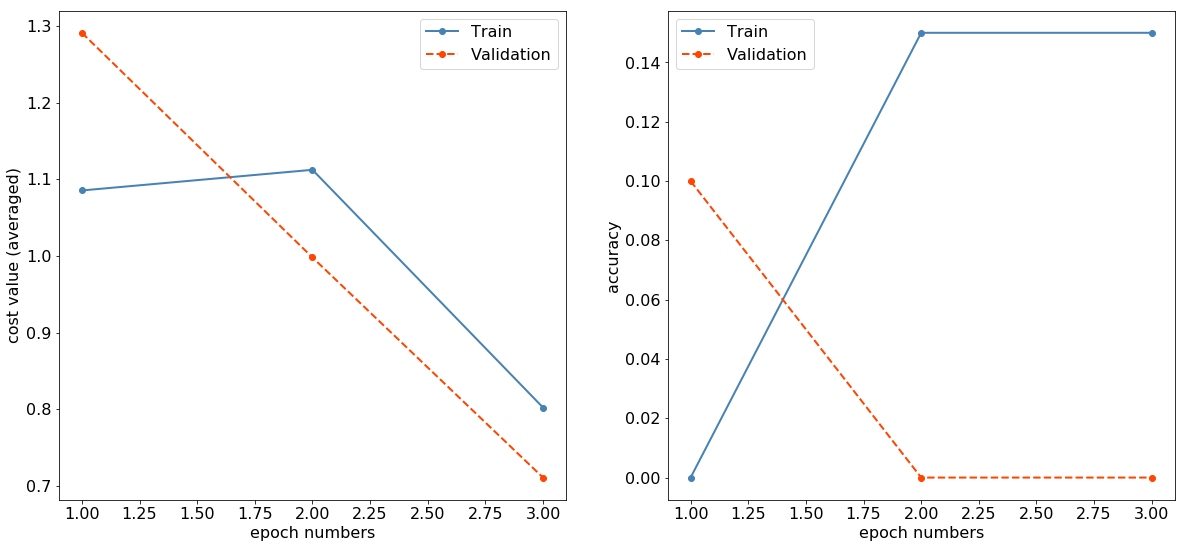

In [400]:
# 演算処理に大量の時間がかかるため、エポック数、サンプル数を限定して実行
scratch_1d_cnn = Scratch1dCNNClassifier(
    FN=5, C=1, FS=200, n_nodes1=400, n_nodes2=200, n_epochs=3, learning_method="SGD", 
    alpha=2e-4, batch_size=20, sigma="He", activation="ReLU", random_seed=0, verbose=True)

scratch_1d_cnn.fit(X_train[:20, :, :], y_train[:20], X_val[:10, :, :], y_val[:10])

コスト関数値は下がっているが、精度が上がらない。今回は実務上あまり利用しない1dによる実装であり、さらに適切な層の構成やパラメータが不明なため、学習の最適化が困難であった。また、演算処理の爆発的な増加により学習サンプル数とエポック数を大幅に削減する必要があり、今後の実務的な実装にはGPUの利用を検討する必要がある。